<h1 style="text-align: center;" markdown="1">Machine Learning Algorithms for Digital Wage Payment Prediction</h1> 
<h2 style="text-align: center;" markdown="2">An AIMS Masters project in Collaboration with the Global Centre on Digital Wages for Decent Work (ILO)</h2>


> *The widespread adoption of digital payments has become increasingly important. In light of this, the aim of this project is to investigate the probability of an individual receiving digital wages in Africa. To achieve this, a series of empirical comparative assessments of machine learning classification algorithms will be conducted. The objective is to determine the effectiveness of these algorithms in predicting digital wage payments. Therefore, this notebook forms part of a larger project that seeks to explore the potential of machine learning in addressing issues related to financial inclusion in Africa.*

<h1 style="text-align: center;" markdown="3">Error Analaysis Part 2: Misclassification Analysis</h1> 


# Table of Contents
[Introduction](#introduction)  

[Misclassification Confidence](#confidence)

[Load Expenditure Data](#loadexp)

[Load FP/FN](#loadfpfn)

[Plot FP and FN](#plotfpfn)

[Plot Consumption Rate](#consrate)

[Jaccard Similarity](#jsim)

[Summary](#summary)



# Misclassification Analysis Introduction <a class="anchor" id="introduction"></a>

In this notebook, we use the error `DataFrame`s generated in the previous notebook (`18.1a-error-analysis.ipynb`) to examine various perperties of the misclassifications. First, we'll look at the concentration of false positives and false negatives around the poverty line. Next, we'll visualize the model confidences for the misclassifications. Then we'll consider aggregate consumption patterns present in the dataset to see if false positive and false negative misclassifications are more similar to the poor or non-poor class.

First, we load the standard libraries as usual:

In [1]:
%matplotlib inline

import os
from pathlib import Path
import sys
import json

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 450)

from pandas.io.stata import StataReader
from tqdm import tqdm

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set(style="white", context="paper")
plt.rc("axes.spines", top=False, right=False, left=False, bottom=False)
import scienceplots
plt.style.context(['science', 'ieee', 'high-vis'])
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

sys.path.append(os.path.join(os.pardir, 'src'))
from data import load_data

from sklearn.model_selection import train_test_split

ERRORS_DIR = Path('..', 'data', 'processed', 'best models', 'errors')

# Load Expenditure Data <a class="anchor" id="loadexp"></a>

To measure distances from the poverty line, we'll need to know a household's actual expenditure (not just whether or not it's anove or below the poverty line). To get this information, we'll have to go back to the raw data.

## Load original household data

Below we'll re-define the utility function used to load the original stata files and convert them to properly formatted Pandas DataFrames. The function will be used to load the class data (poor vs. non-poor) as well as the expenditure data. We can then verify the consistency between the two sources before proceeeding.

In [2]:
def load_csv_file(filepath):
    
    """ 
    Load data in correct format from CSV file
    
    Parameters:
    -----------
    filepath : a filepath to the file to be loaded
        
    Returns:
    --------
    data: the processed dataframe 
    
    """
    data = pd.read_csv(filepath)
    
    #drop the regionwb column
    data.drop(['regionwb', 'receive_welfare_payments'], axis=1, inplace = True)
    
    #define function to categorize age
    def categorize_age(data):
        data.loc[(data['age'] >= 15) & (data['age'] <= 24), 'age'] = 1
        data.loc[(data['age'] >= 25) & (data['age'] <= 44), 'age'] = 2
        data.loc[(data['age'] >= 45) & (data['age'] <= 64), 'age'] = 3
        data.loc[data['age'] >= 65, 'age'] = 4
        data['age'] = data['age'].astype('category')
        return data
    # call the function and assign the returned value back to data
    data = categorize_age(data)
    
    # convert those who responded to receiving wages through other methods to digital wage receipients
    # and rename the variable from receive_wages to receive_digital_wages
    data.loc[data.receive_wages == 3, 'receive_wages'] = 1
    data.rename( columns={'receive_wages':'receive_digital_wages'}, inplace=True )
    
    # rename the first column to be id (referencing row position in original uncleaned data) and setting it as index
    data.rename( columns={'Unnamed: 0':'id'}, inplace=True )
    data.set_index('id', inplace = True)
    
    numeric_variables = ['pop_scaled_wgt']
    # convert the categorical variables into the category type
    for c in data.columns:
        if c not in numeric_variables:
            data[c] = data[c].astype('category')
    
    #Drop Algeria, Gabon, Mauritius and Morocco due to missing values not at random
    data.dropna(subset = ['urbanicity_f2f'], inplace=True)
    
    data['economy'] = data['economy'].cat.remove_unused_categories()
      
    return data

Select just the columns we need for this verification.

  - household size
  - household weight
  - create boolean poor/non-poor based on string column `poor`

In [3]:
filepath = load_data.FULL_MERGED
full_merged_data = load_csv_file(filepath)

full_merged_data.receive_digital_wages = (full_merged_data.receive_digital_wages == 1)
full_merged_data.head()


,economy,pop_scaled_wgt,female,age,educ,inc_q,emp_in,urbanicity_f2f,account,fin14_1,...,fin22b,fin24,fin33,receive_digital_wages,pay_utilities,remittances,mobileowner,internetaccess,merchantpay_dig,internet_fin_transc
id,,,,,,,,,,,,,,,,,,,,,
9023,Benin,4731.949144,2,1.0,2,5,1.0,1.0,1,2,...,2,2,2.0,False,4,1.0,1,1,0.0,1
9026,Benin,4469.830001,1,1.0,2,3,1.0,2.0,1,2,...,2,1,2.0,True,2,1.0,1,2,0.0,2
9027,Benin,17001.509861,1,3.0,2,5,1.0,2.0,1,2,...,1,2,1.0,True,1,1.0,1,1,0.0,1
9028,Benin,9407.418933,2,1.0,2,2,1.0,1.0,1,2,...,2,3,2.0,False,4,1.0,1,1,0.0,1
9034,Benin,4830.758167,2,3.0,2,5,1.0,1.0,1,2,...,1,2,1.0,True,4,1.0,1,2,0.0,1


In [4]:
full_merged_data.loc[60068]

economy                        Kenya
pop_scaled_wgt           11287.20454
female                             2
age                              2.0
educ                               2
inc_q                              5
emp_in                           1.0
urbanicity_f2f                   2.0
account                            1
fin14_1                            2
fin16                              1
fin17a                             1
fin17b                           1.0
fin22a                             2
fin22b                             2
fin24                              1
fin33                            2.0
receive_digital_wages           True
pay_utilities                      1
remittances                      1.0
mobileowner                        1
internetaccess                     1
merchantpay_dig                  1.0
internet_fin_transc                1
Name: 60068, dtype: object

In [5]:
# ~10% poor, which is correct
full_merged_data.receive_digital_wages.value_counts()

True     3685
False    2121
Name: receive_digital_wages, dtype: int64

# Load FP/FN Results<a class="anchor" id="loadfpfn"></a>

Now we can confidently use the expenditure data in our analysis of misclassifications. First let's look at the false positives and false negatives households we extracted in the previous notebook and confirm that they are consistent with the ependiture data. For example, false positively classifed (predicted poor, labeled non-poor) households should have ependitures _aobve_ the poverty line, and vice versa for false negatives.

 - Load both of the files for false positives and false negatives
 - Create masks of rows that have at least one false positive or false negative

In [6]:
fp = pd.read_csv(Path(ERRORS_DIR, "fp_top_3_models.csv"), index_col='id')
fn = pd.read_csv(Path(ERRORS_DIR, "fn_top_3_models.csv"), index_col='id')

In [7]:
fp.rename(columns={"xgb_final": "XGBoost", "lr_final": "Linear Regression", "rf_final": "Random Forest"}, inplace = True)
fn.rename(columns={"xgb_final": "XGBoost", "lr_final": "Linear Regression", "rf_final": "Random Forest"}, inplace = True)

<AxesSubplot:ylabel='Frequency'>

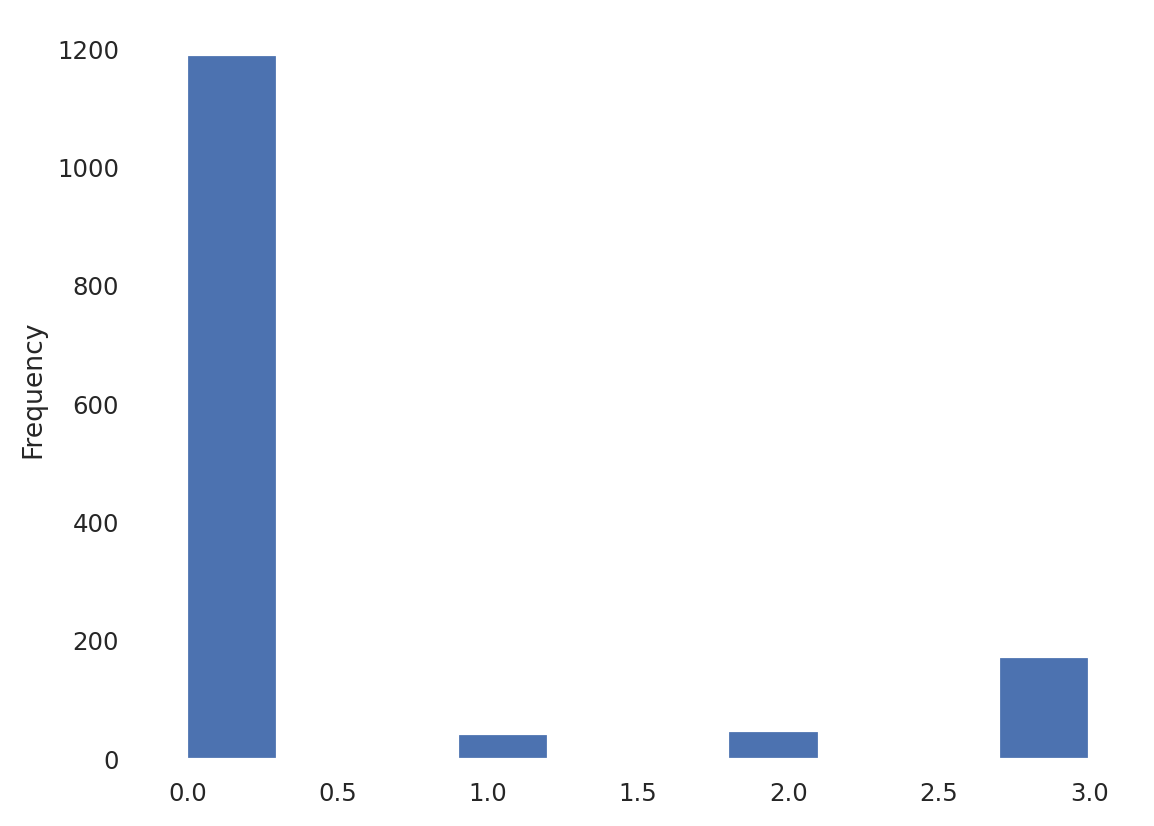

In [8]:
fp.sum(axis=1).plot.hist()

<AxesSubplot:ylabel='Frequency'>

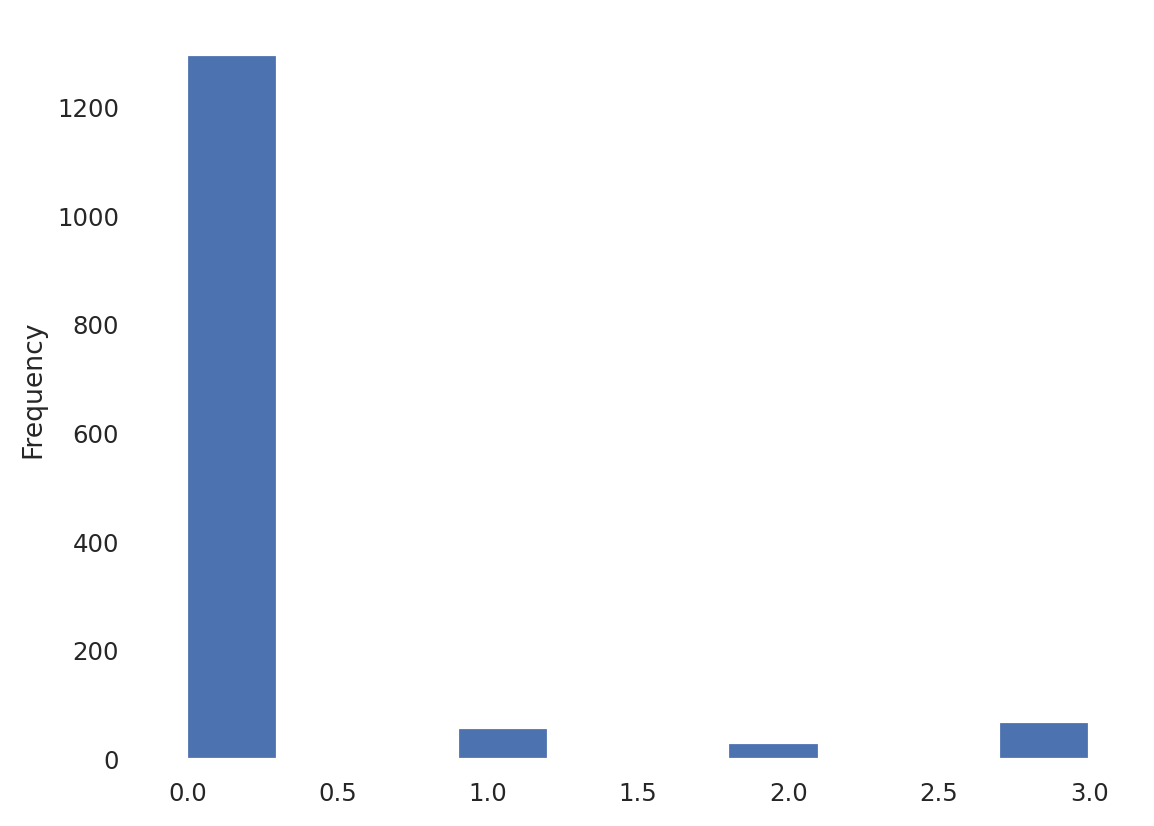

In [9]:
fn.sum(axis=1).plot.hist()

In [10]:
# join with expenditure data
exp_and_fp = fp.join(full_merged_data)
exp_and_fn = fn.join(full_merged_data)

In [11]:
# households with at least one false negative model (models are first twenty columns)
has_a_false_neg = exp_and_fn[exp_and_fn.iloc[:, :3].any(axis=1)]

# households with at least one false positive model (models are first twenty columns)
has_a_false_pos = exp_and_fp[exp_and_fp.iloc[:, :3].any(axis=1)]

In [12]:
exp_and_fn

,XGBoost,Linear Regression,Random Forest,y_test,economy,pop_scaled_wgt,female,age,educ,inc_q,...,fin22b,fin24,fin33,receive_digital_wages,pay_utilities,remittances,mobileowner,internetaccess,merchantpay_dig,internet_fin_transc
id,,,,,,,,,,,,,,,,,,,,,
118568,False,False,False,False,Uganda,5691.141620,1,1.0,2,5,...,1,3,1.0,True,4,1.0,1,1,0.0,1
60068,False,False,False,False,Kenya,11287.204540,2,2.0,2,5,...,2,1,2.0,True,1,1.0,1,1,1.0,1
32028,False,False,False,False,"Egypt, Arab Rep.",15661.994093,2,2.0,2,5,...,1,3,2.0,False,2,5.0,1,1,0.0,2
112968,False,False,False,False,Tanzania,14987.057276,2,3.0,1,2,...,2,2,2.0,False,4,5.0,2,2,0.0,2
32075,False,False,False,False,"Egypt, Arab Rep.",202831.392161,2,1.0,3,5,...,2,5,2.0,True,4,5.0,1,1,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118566,False,False,False,False,Uganda,11204.619262,1,2.0,2,2,...,1,1,2.0,True,1,1.0,2,2,1.0,1
83644,False,False,False,False,Nigeria,154713.829559,2,1.0,2,1,...,1,5,2.0,False,4,3.0,1,1,0.0,2
39784,True,True,True,False,Ghana,32824.340432,1,2.0,1,1,...,1,2,2.0,True,4,1.0,1,2,0.0,1


### All False negatives are actually "Poor" (we predicted "non-poor", which is negative) 

 - `True` for the original boolean provided to us
 - also true if recalculated from expenditure data

In [13]:
exp_and_fn.loc[has_a_false_neg.index].receive_digital_wages.value_counts()

True    155
Name: receive_digital_wages, dtype: int64

### All False positives are actually "Non-Poor" (we predicted "poor", which is positive) 

 - true for the original boolean provided to us
 - also true if recalculated from expenditure data

In [14]:
exp_and_fp.loc[has_a_false_pos.index].receive_digital_wages.value_counts()

False    262
Name: receive_digital_wages, dtype: int64

# Misclassification Confidence <a class="anchor" id="confidence"></a>

Here we'll create a plot that shows the spread of modelconfidences for each error type, grouped by model, and sorted from left to right according to the average median error of the model. Recall that most of the classifiers in this report (and all of the top classifiers) produce probabilities for the two possible class labels.  The probabilities are then rounded to 0 (non-poor) or 1 (poor) to generate a class prediction. This means that there is apossible error range of 0.5: a model that predicts a household labeled “poor” to be “non-poor” (false negative) with probability 0 is the maximum possible distance of 0.5 away from the threshold that would have led to a correct prediction (true positive). Similarly, a model that predicts a household labeled “Non-Poor” to be “Poor” (false positive) is the maximum possible distance of 0.5 away fromthe threshold that would have led to a correct prediction (true negative).

To create the plot, we'll use the false positive and false negative DataFrames, as well as the DataFrame with all predicted probabilites.

In [15]:
# set index back to int
fp.index = fp.index.astype(int)
fn.index = fn.index.astype(int)

# load all predicted probabilies
all_probs = pd.read_csv(Path(ERRORS_DIR, 'all_probs_top_3_models.csv'), index_col='id')
all_probs.rename(columns={"xgb_final": "XGBoost", "lr_final": "Linear Regression", "rf_final": "Random Forest"}, inplace = True)

In [16]:
all_probs

,XGBoost,Linear Regression,Random Forest,y_test
id,,,,
118568,0.922600,0.798149,0.830746,True
60068,0.951622,0.958456,0.954610,True
32028,0.000888,0.049829,0.060399,False
112968,0.067066,0.043772,0.059202,False
32075,0.670581,0.803972,0.585474,True
...,...,...,...,...
118566,0.656528,0.903681,0.870541,True
83644,0.493885,0.617698,0.368034,False
39784,0.350540,0.396484,0.484755,True


Get model names 

In [17]:
model_names = fp.drop('y_test', axis=1).columns
model_names

Index(['XGBoost', 'Linear Regression', 'Random Forest'], dtype='object')

In order to plot these models together, we need to change the orientation of the data. We'll use the `melt` function in pandas to create the data format we need for our plots.

In [18]:
melt_fp = pd.melt(fp.reset_index(), id_vars=['id'], value_vars=model_names, var_name='Model', value_name='Error Type')
melt_fp = melt_fp[melt_fp['Error Type'] != False]
melt_fp['Error Type'] = 'False Positive'

melt_fn = pd.melt(fn.reset_index(), id_vars=['id'], value_vars=model_names, var_name='Model', value_name='Error Type')
melt_fn = melt_fn[melt_fn['Error Type'] != False]
melt_fn['Error Type'] = 'False Negative'

melt_conf = pd.melt(all_probs.reset_index(), id_vars=['id'], value_vars=model_names, var_name='Model', value_name='Error')
melt_conf['Error'] = melt_conf['Error'].map(lambda x: 1 - x if x > 0.5 else x)

melt_errs = pd.concat((melt_fp, melt_fn))
melt_conf = melt_conf.loc[melt_errs.index]

melted = melt_errs.merge(melt_conf, on=['id', 'Model'])
melted.sample(417)

,id,Model,Error Type,Error
284,55782,Linear Regression,False Positive,0.327514
252,125958,Linear Regression,False Positive,0.469153
203,98430,XGBoost,False Positive,0.367432
742,16744,XGBoost,False Negative,0.468547
222,66090,XGBoost,False Positive,0.455710
920,60344,Random Forest,False Negative,0.423997
814,40107,Linear Regression,False Negative,0.447170
712,76608,XGBoost,False Negative,0.240451
103,55215,XGBoost,False Positive,0.411775
729,126578,XGBoost,False Negative,0.408425


In [20]:
ordered_by_median = melted.groupby('Model')['Error'].median().sort_values().index.values

Create plot

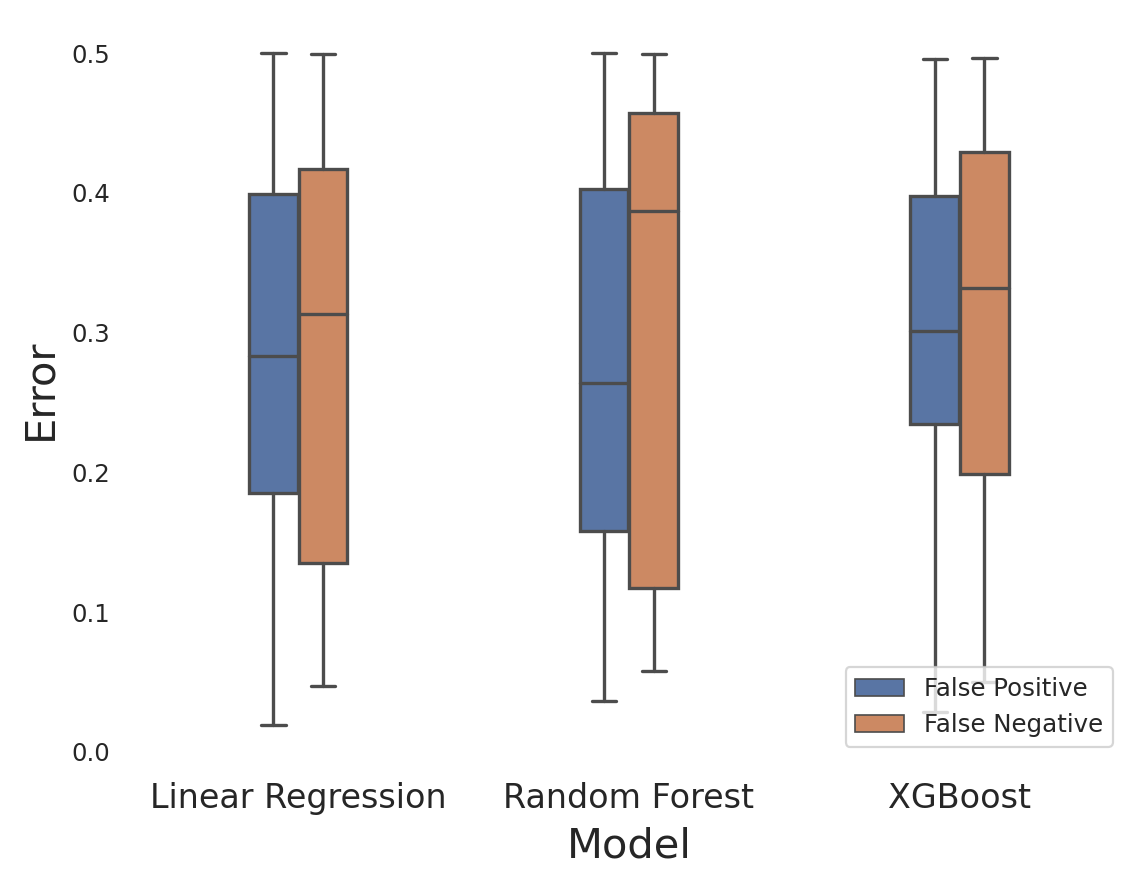

In [21]:
fig, ax = plt.subplots()

# fig.set_size_inches(22, 8.27)

sns.boxplot(x='Model', y='Error', hue='Error Type', data=melted, ax=ax, width=0.3, order=ordered_by_median)

ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=12)
plt.xlabel(ax.get_xlabel(), fontsize=15)
plt.ylabel(ax.get_ylabel(), fontsize=15)
# plt.setp(ax.legend(bbox_to_anchor=(1, 1), title="Error Type", fontsize=15).get_title(),fontsize=12);
# ax.legend(loc="upper right", fontsize=12)
plt.legend(loc="lower right", ncol=1)
plt.savefig("img/errorboxplot.png", dpi=500)

 A tighter box indicates less variability in model confidence, so for example the “svm_full_classwts” model consistently almost correctly predicted its false negative households, because the false negative box (green) is close to 0 error and has a maximum error of less than 0.1.  The same model’s false positive box (blue) however, has much more variability, with minimum errors close to 0 and maximum errors at the global maximum of 0.5. In this sense, the spread of a box in these plots can be taken to correspond to model consistency. Additionally, note that the “deepfm_full_cv,” which is one of the overall top performing models, consistently makes almost the maximum possible error in its false positive (blue) predictions, indicating a high but incorrect model confidence.

# Plot Consumption Rate <a class="anchor" id="consrate"></a>

The following DataFrames are indexed by household, with the first $N$ columns labeled by model (disregard the remaining columns, which contain additional information such as the ground truth label, distance from the poverty line, and more). Each entry in these first $N$ columns is boolean.

**`exp_and_fn`:** Entry $(i,j)$ is `True` if household $i$ is poor but was classified as non-poor (false negative). The entry is `False` otherwise.

**`exp_and_fp`:** Entry $(i,j)$ is `True` if household $i$ is non-poor but was classified as poor (false positive). The entry is `False` otherwise.



In [22]:
exp_and_fn.iloc[:, :20].sample(10)

,XGBoost,Linear Regression,Random Forest,y_test,economy,pop_scaled_wgt,female,age,educ,inc_q,emp_in,urbanicity_f2f,account,fin14_1,fin16,fin17a,fin17b,fin22a,fin22b,fin24
id,,,,,,,,,,,,,,,,,,,,
104540,False,False,False,False,South Africa,16389.226315,1,3.0,2,5,2.0,2.0,1,2,1,1,2.0,2,2,1
118797,False,False,False,False,Uganda,19374.635548,1,2.0,1,1,1.0,2.0,1,2,2,2,2.0,2,2,5
14079,False,False,False,False,Burkina Faso,3450.680900,1,2.0,2,5,1.0,2.0,1,2,1,1,1.0,2,2,1
115261,False,False,False,False,Togo,3110.459345,1,1.0,2,2,1.0,1.0,0,2,2,2,1.0,2,2,2
31819,False,False,False,False,"Egypt, Arab Rep.",44676.979565,2,2.0,1,3,1.0,2.0,0,2,2,2,2.0,2,2,3
67834,False,False,False,False,Malawi,3751.808868,2,2.0,2,5,1.0,2.0,1,2,2,2,1.0,1,1,4
98097,True,True,False,False,Senegal,2020.324902,2,1.0,2,4,1.0,2.0,1,2,2,2,2.0,2,1,2
75746,False,False,False,False,Mozambique,3301.779976,2,2.0,2,5,1.0,2.0,1,2,2,2,2.0,2,2,3
70672,False,False,False,False,Mali,2448.753935,2,2.0,2,5,1.0,2.0,1,2,1,1,2.0,2,2,1


In [23]:
exp_and_fp.iloc[:, :20].sample(10)

,XGBoost,Linear Regression,Random Forest,y_test,economy,pop_scaled_wgt,female,age,educ,inc_q,emp_in,urbanicity_f2f,account,fin14_1,fin16,fin17a,fin17b,fin22a,fin22b,fin24
id,,,,,,,,,,,,,,,,,,,,
14504,False,False,False,False,Burkina Faso,16312.347192,2,1.0,1,1,1.0,1.0,1,2,1,1,1.0,1,1,3
23555,False,False,False,False,"Congo, Rep.",803.478098,2,2.0,2,5,1.0,2.0,0,2,2,2,2.0,2,2,2
67839,True,True,True,False,Malawi,6167.472666,1,2.0,1,1,1.0,1.0,1,2,2,2,1.0,1,1,4
115283,False,False,False,False,Togo,1485.017799,1,2.0,2,4,1.0,1.0,0,2,2,2,2.0,2,2,3
77886,False,False,False,False,Namibia,1586.555326,2,2.0,3,3,1.0,1.0,1,2,1,1,2.0,2,1,4
126217,True,False,False,False,Zambia,3977.498318,1,2.0,2,3,1.0,2.0,1,2,2,2,2.0,2,2,7
126482,False,False,False,False,Zambia,5516.215648,2,2.0,1,4,1.0,1.0,1,1,2,1,2.0,2,1,2
16706,True,True,True,False,Cameroon,11149.921485,2,2.0,2,4,1.0,2.0,1,2,1,2,1.0,2,1,3
100719,False,False,False,False,Sierra Leone,1576.638021,2,3.0,2,5,1.0,2.0,1,2,2,2,1.0,2,2,3


In [24]:
len(exp_and_fn)

1452

<AxesSubplot:>

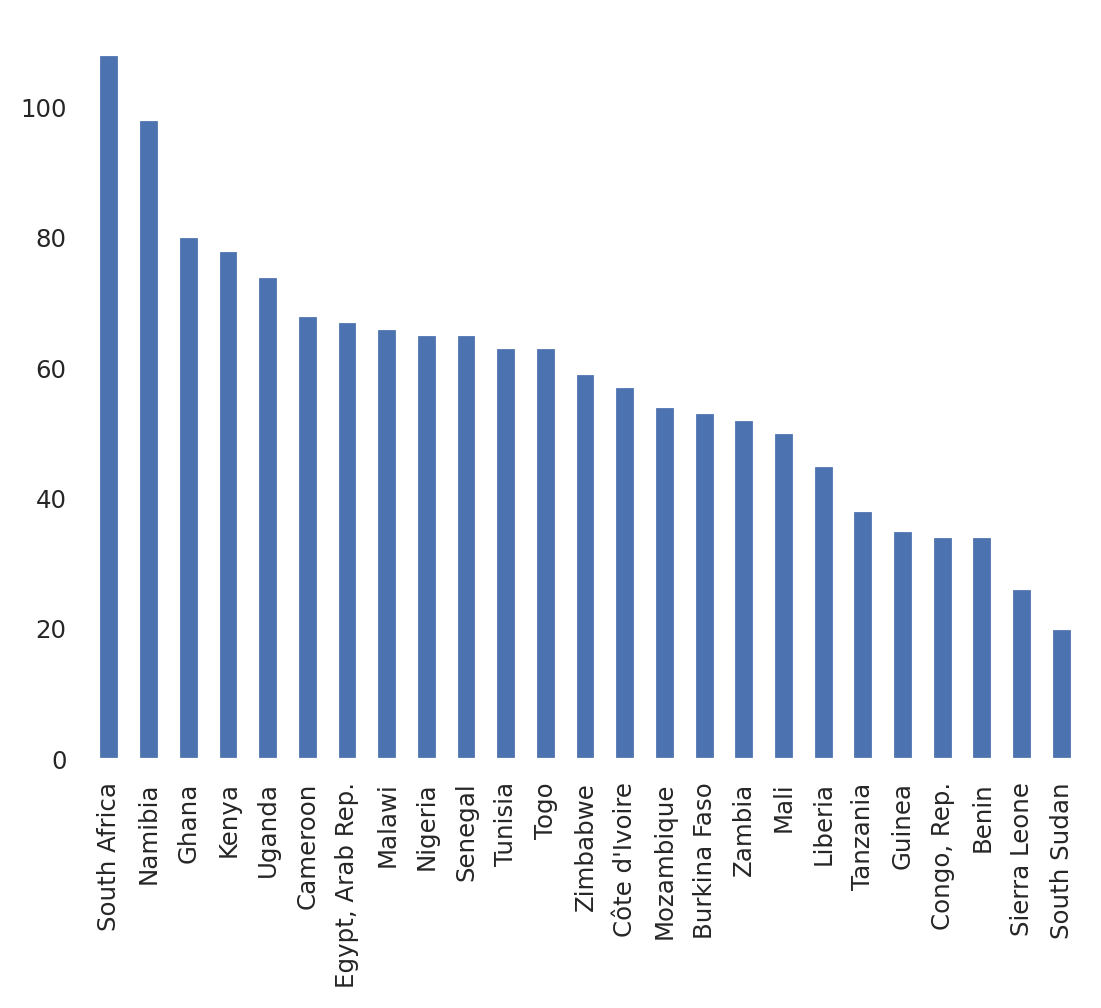

In [25]:
exp_and_fp.economy.value_counts().plot(kind='bar')

<AxesSubplot:>

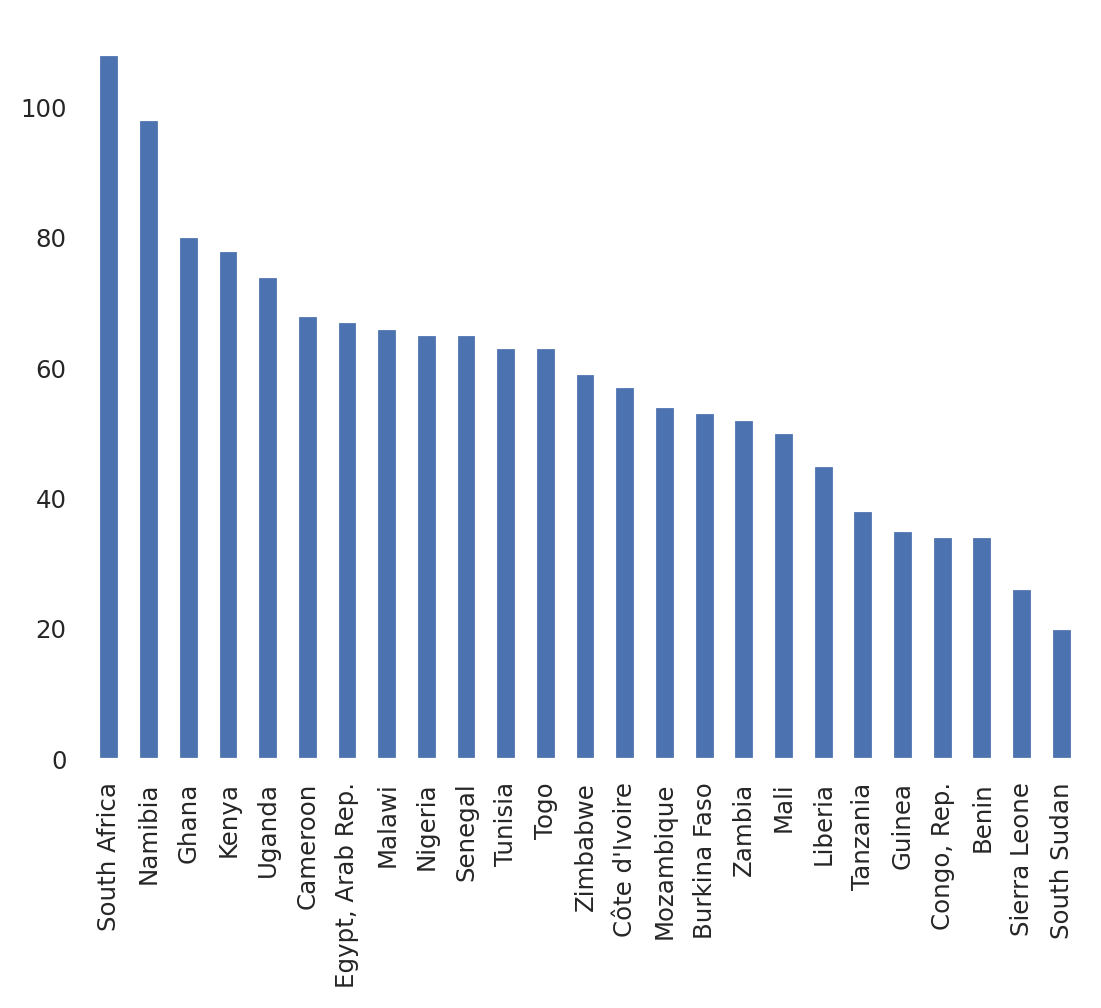

In [26]:
exp_and_fn.economy.value_counts().plot(kind='bar')

To simplify our description of misclassifications, we say that a given household *has* a false positive (negative) model if at least 5 models have misclassified the household in that way (type 1 error i.e., false positive, or type 2 error i.e., false negative).

In [27]:
N = 3

# households with at least 5 false negative model (first twenty columns)
has_a_false_neg = exp_and_fn.iloc[:, :3].sum(axis=1) >= N
has_a_false_neg_idx = has_a_false_neg[has_a_false_neg == True].index
num_false_neg = exp_and_fn.loc[has_a_false_neg].iloc[:, :3].sum(axis=1)

# households with at least 5 false positive model (first twenty columns)
has_a_false_pos = exp_and_fp.iloc[:, :3].sum(axis=1) >= N
has_a_false_pos_idx = has_a_false_pos[has_a_false_pos == True].index
num_false_pos = exp_and_fp.loc[has_a_false_pos].iloc[:, :3].sum(axis=1)

In [28]:
exp_and_fn_3 = exp_and_fn.loc[has_a_false_neg_idx]
exp_and_fp_3 = exp_and_fp.loc[has_a_false_pos_idx]

In [29]:
has_a_false_neg_idx.isin(has_a_false_pos_idx).sum()

0

In [30]:
has_a_false_pos_idx.isin(has_a_false_neg_idx).sum()

0

<AxesSubplot:>

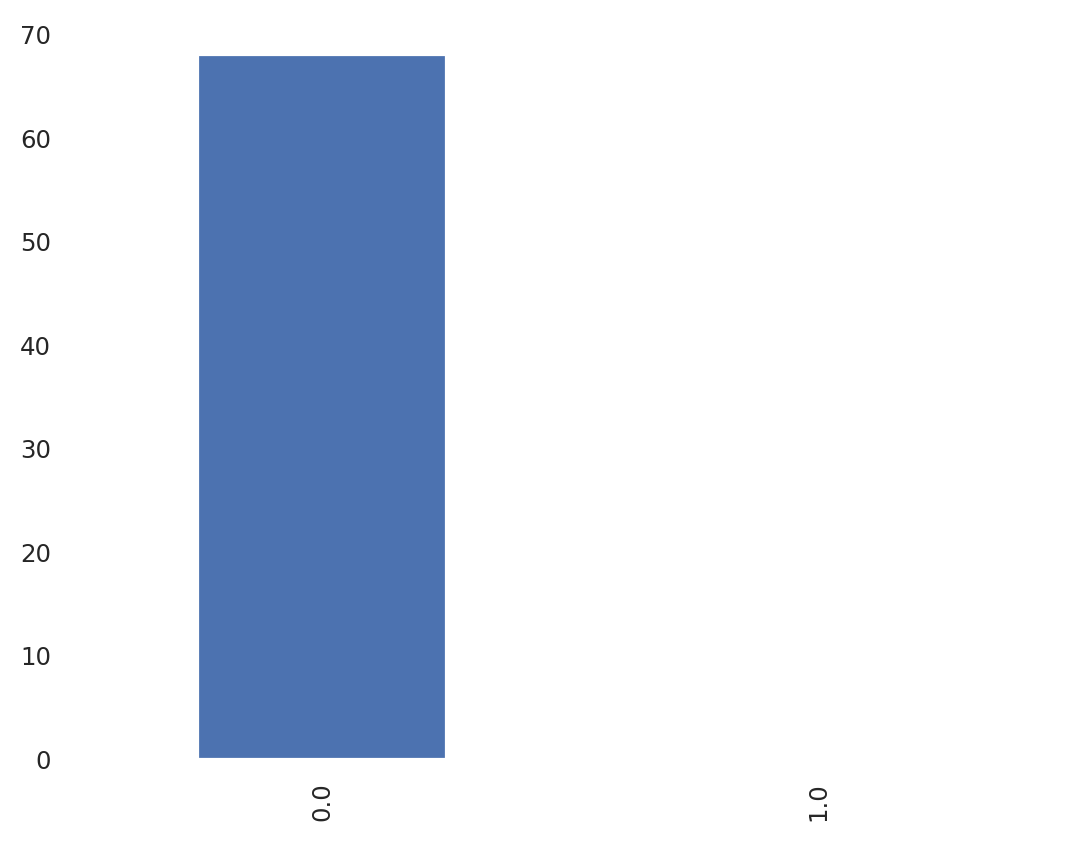

In [31]:
exp_and_fn_3.merchantpay_dig.value_counts().plot(kind='bar')

<AxesSubplot:>

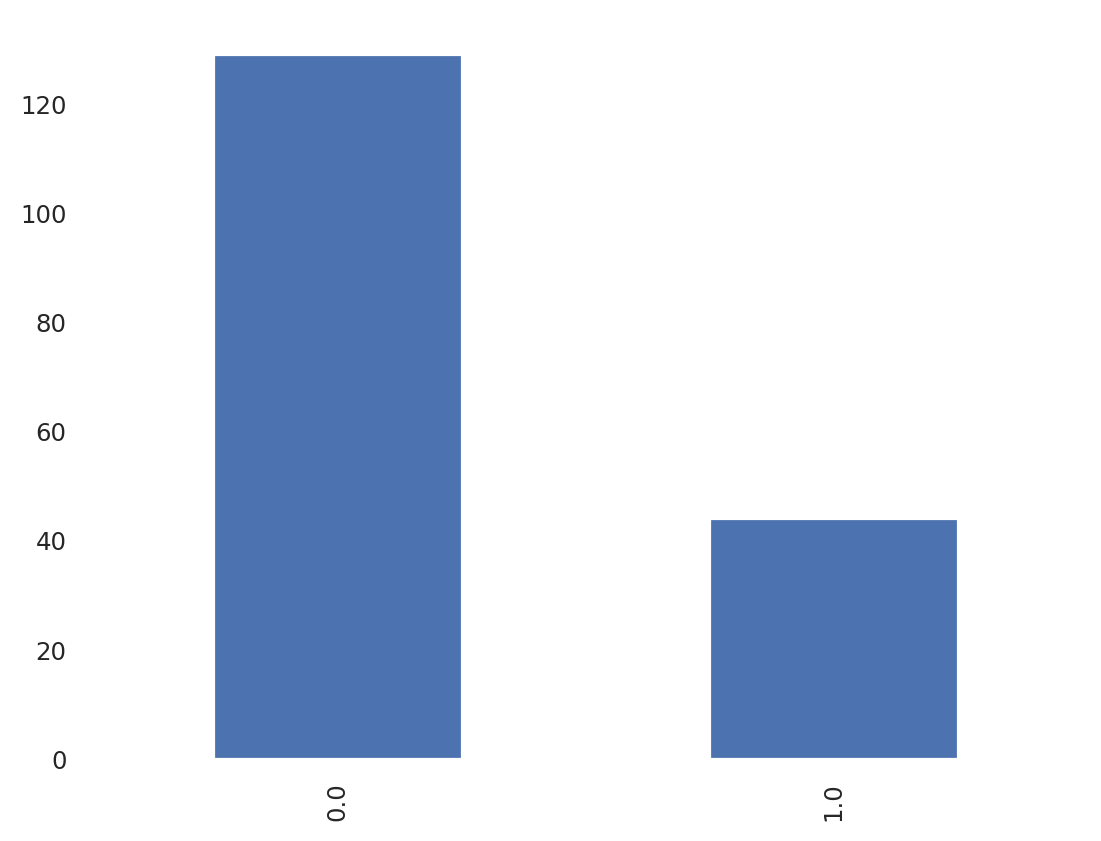

In [32]:
exp_and_fp_3.merchantpay_dig.value_counts().plot(kind='bar')

In [40]:
# Add column indicating dataset
exp_and_fp_3['Error Type'] = 'False Positive'
exp_and_fn_3['Error Type'] = 'False Negative'

# Concatenate dataframes vertically
merged_df = pd.concat([exp_and_fp_3, exp_and_fn_3], axis=0)

# Reset index to avoid ignoring it
merged_df = merged_df.reset_index()
merged_df.set_index("id", inplace=True)
merged_df.drop(['XGBoost', 'Linear Regression', 'Random Forest', 'y_test', 'pop_scaled_wgt', 'receive_digital_wages'], axis=1, inplace = True)

In [79]:
merged_df#.columns.to_list()

,economy,female,age,educ,inc_q,emp_in,urbanicity_f2f,account,fin14_1,fin16,...,fin22b,fin24,fin33,pay_utilities,remittances,mobileowner,internetaccess,merchantpay_dig,internet_fin_transc,Error Type
id,,,,,,,,,,,,,,,,,,,,,
127600,Zimbabwe,2,2.0,2,4,1.0,2.0,1,1,2,...,2,4,2.0,2,2.0,1,1,1.0,1,False Positive
9596,Benin,1,2.0,2,5,1.0,2.0,1,2,2,...,1,3,2.0,4,1.0,1,1,0.0,1,False Positive
66052,Liberia,1,3.0,1,5,1.0,2.0,1,2,1,...,1,2,1.0,4,1.0,1,1,0.0,1,False Positive
98273,Senegal,2,2.0,2,3,1.0,1.0,1,2,2,...,1,5,2.0,1,1.0,1,1,0.0,1,False Positive
66145,Liberia,1,2.0,2,5,1.0,2.0,1,2,2,...,1,5,1.0,2,1.0,1,1,0.0,2,False Positive
65870,Liberia,1,1.0,2,5,2.0,2.0,1,2,2,...,2,4,2.0,2,1.0,1,1,0.0,2,False Positive
104121,South Africa,2,1.0,2,5,2.0,1.0,1,2,2,...,1,7,2.0,4,2.0,1,1,1.0,1,False Positive
24044,"Congo, Rep.",2,2.0,3,5,1.0,2.0,1,2,2,...,2,3,2.0,2,1.0,1,2,0.0,1,False Positive
70312,Mali,2,2.0,2,5,1.0,2.0,1,2,2,...,1,1,2.0,1,5.0,1,1,0.0,1,False Positive


#### Account vs Gender

In [303]:
from matplotlib.markers import MarkerStyle
import numpy as np
import matplotlib.pyplot as plt

def categorical_bubble_plot_g(dataframe, X, Y, H, ax):
    bin_dic = {0: "False Positive", 1: "False Negative"}

    # counting the X-Y-H category entries
    plt_df = dataframe.groupby([X, Y, H]).size().to_frame(name="vals").reset_index()

    # figure preparation with grid and scaling
#     fig, ax = plt.subplots(figsize=(9, 6))
#     ax.set_ylim(plt_df[Y].unique().size-0.5, -0.5)
#     ax.set_xlim(-0.5, plt_df[X].unique().size+1.0)
    ax.set_ylim(0.5, 3)
    ax.set_xlim(-0.5, 2)
    ax.grid(ls="--")

    # upscale factor for scatter marker size
    scale=1500/plt_df.vals.max()
    # left marker for category 0
    ax.scatter(plt_df[plt_df[H]==bin_dic[0]][X], 
               plt_df[plt_df[H]==bin_dic[0]][Y], 
               s=plt_df[plt_df[H]==bin_dic[0]].vals*scale, 
               c=[(0, 0.1, 0.8, 0.8)], edgecolor="black", marker=MarkerStyle("o", fillstyle="left"), 
               label=bin_dic[0])
    # right marker for category 1
    ax.scatter(plt_df[plt_df[H]==bin_dic[1]][X], 
               plt_df[plt_df[H]==bin_dic[1]][Y], 
               s=plt_df[plt_df[H]==bin_dic[1]].vals*scale, 
               c=[(0, 0.5, 0, 0.9)], edgecolor="black", marker=MarkerStyle("o", fillstyle="right"), 
               label=bin_dic[1])

    a=ax.get_xticks().tolist()
    a[0], a[1], a[2], a[3], a[4], a[5] ='', 'Owner', '', 'Not owner', '', ''
    ax.set_xticklabels(a)
    b=ax.get_yticks().tolist()
    b[0], b[1], b[2], b[3], b[4], b[5] ='', 'Female', '', 'Male', '', ''
    ax.set_yticklabels(b)
    ax.set_xlabel("Account", fontsize=15)
    ax.set_ylabel("Gender", fontsize=15)
#     plt.show()
X ="account" 
Y = "female"
H ="Error Type"
# categorical_bubble_plot_g(merged_df, X, Y, H)

#### Account vs Age

In [304]:
from matplotlib.markers import MarkerStyle
import numpy as np
import matplotlib.pyplot as plt

def categorical_bubble_plot_a(dataframe, X, Y, H, ax):
    bin_dic = {0: "False Positive", 1: "False Negative"}

    # counting the X-Y-H category entries
    plt_df = dataframe.groupby([X, Y, H]).size().to_frame(name="vals").reset_index()

    # figure preparation with grid and scaling
#     fig, ax = plt.subplots(figsize=(9, 6))
#     ax.set_ylim(plt_df[Y].unique().size-0.5, -0.5)
#     ax.set_xlim(-0.5, plt_df[X].unique().size+1.0)
    ax.set_ylim(0, 5)
    ax.set_xlim(-0.5, 2)
    ax.grid(ls="--")

    # upscale factor for scatter marker size
    scale=1500/plt_df.vals.max()
    # left marker for category 0
    ax.scatter(plt_df[plt_df[H]==bin_dic[0]][X], 
               plt_df[plt_df[H]==bin_dic[0]][Y], 
               s=plt_df[plt_df[H]==bin_dic[0]].vals*scale, 
               c=[(0, 0.1, 0.8, 0.8)], edgecolor="black", marker=MarkerStyle("o", fillstyle="left"), 
               label=bin_dic[0])
    # right marker for category 1
    ax.scatter(plt_df[plt_df[H]==bin_dic[1]][X], 
               plt_df[plt_df[H]==bin_dic[1]][Y], 
               s=plt_df[plt_df[H]==bin_dic[1]].vals*scale, 
               c=[(0, 0.5, 0, 0.9)], edgecolor="black", marker=MarkerStyle("o", fillstyle="right"), 
               label=bin_dic[1])

    a=ax.get_xticks().tolist()
    a[0], a[1], a[2], a[3], a[4], a[5] ='', 'Owner', '', 'Not owner', '', ''
    ax.set_xticklabels(a)
    b=ax.get_yticks().tolist()
    b[0], b[1], b[2], b[3], b[4], b[5] ='', '15-24', '25-44', '45-64', '65+', ''
    ax.set_yticklabels(b)
    ax.set_xlabel("Account", fontsize=15)
    ax.set_ylabel("Age", fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=15)
#     plt.show()
X ="account" 
Y = "age"
H ="Error Type"
# categorical_bubble_plot_a(merged_df, X, Y, H)

#### Account vs Education

In [305]:
from matplotlib.markers import MarkerStyle
import numpy as np
import matplotlib.pyplot as plt

def categorical_bubble_plot_e(dataframe, X, Y, H, ax):
    bin_dic = {0: "False Positive", 1: "False Negative"}

    # counting the X-Y-H category entries
    plt_df = dataframe.groupby([X, Y, H]).size().to_frame(name="vals").reset_index()

    # figure preparation with grid and scaling
#     fig, ax = plt.subplots(figsize=(9, 6))
#     ax.set_ylim(plt_df[Y].unique().size-0.5, -0.5)
#     ax.set_xlim(-0.5, plt_df[X].unique().size+1.0)
    ax.set_ylim(0, 5)
    ax.set_xlim(-0.5, 2)
    ax.grid(ls="--")

    # upscale factor for scatter marker size
    scale=1500/plt_df.vals.max()
    # left marker for category 0
    ax.scatter(plt_df[plt_df[H]==bin_dic[0]][X], 
               plt_df[plt_df[H]==bin_dic[0]][Y], 
               s=plt_df[plt_df[H]==bin_dic[0]].vals*scale, 
               c=[(0, 0.1, 0.8, 0.8)], edgecolor="black", marker=MarkerStyle("o", fillstyle="left"), 
               label=bin_dic[0])
    # right marker for category 1
    ax.scatter(plt_df[plt_df[H]==bin_dic[1]][X], 
               plt_df[plt_df[H]==bin_dic[1]][Y], 
               s=plt_df[plt_df[H]==bin_dic[1]].vals*scale, 
               c=[(0, 0.5, 0, 0.9)], edgecolor="black", marker=MarkerStyle("o", fillstyle="right"), 
               label=bin_dic[1])

    a=ax.get_xticks().tolist()
    a[0], a[1], a[2], a[3], a[4], a[5] ='', 'Owner', '', 'Not owner', '', ''
    ax.set_xticklabels(a)
    b=ax.get_yticks().tolist()
    b[0], b[1], b[2], b[3], b[4], b[5] ='', 'Primary school \n or less', 'Secondary school', 'Tertiary education \n or more', '', ''
    ax.set_yticklabels(b)
    ax.set_xlabel("Account", fontsize=15)
    ax.set_ylabel("Educational Attainment Level", fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=15)
#     plt.show()
X ="account" 
Y = "educ"
H ="Error Type"
# categorical_bubble_plot_e(merged_df, X, Y, H)

#### Account vs Income

In [306]:
from matplotlib.markers import MarkerStyle
import numpy as np
import matplotlib.pyplot as plt

def categorical_bubble_plot_i(dataframe, X, Y, H, ax):
    bin_dic = {0: "False Positive", 1: "False Negative"}

    # counting the X-Y-H category entries
    plt_df = dataframe.groupby([X, Y, H]).size().to_frame(name="vals").reset_index()

    # figure preparation with grid and scaling
#     fig, ax = plt.subplots(figsize=(9, 6))
#     ax.set_ylim(plt_df[Y].unique().size-0.5, -0.5)
#     ax.set_xlim(-0.5, plt_df[X].unique().size+1.0)
    ax.set_ylim(0, 6)
    ax.set_xlim(-0.5, 2)
    ax.grid(ls="--")

    # upscale factor for scatter marker size
    scale=1500/plt_df.vals.max()
    # left marker for category 0
    ax.scatter(plt_df[plt_df[H]==bin_dic[0]][X], 
               plt_df[plt_df[H]==bin_dic[0]][Y], 
               s=plt_df[plt_df[H]==bin_dic[0]].vals*scale, 
               c=[(0, 0.1, 0.8, 0.8)], edgecolor="black", marker=MarkerStyle("o", fillstyle="left"), 
               label=bin_dic[0])
    # right marker for category 1
    ax.scatter(plt_df[plt_df[H]==bin_dic[1]][X], 
               plt_df[plt_df[H]==bin_dic[1]][Y], 
               s=plt_df[plt_df[H]==bin_dic[1]].vals*scale, 
               c=[(0, 0.5, 0, 0.9)], edgecolor="black", marker=MarkerStyle("o", fillstyle="right"), 
               label=bin_dic[1])

    a=ax.get_xticks().tolist()
    a[0], a[1], a[2], a[3], a[4], a[5] ='', 'Owner', '', 'Not owner', '', ''
    ax.set_xticklabels(a)
    b=ax.get_yticks().tolist()
    b[0], b[1], b[2], b[3], b[4], b[5], b[6] ='', 'Poorest 20%', 'Second 20%', 'Middle 20%', 'Fourth 20%', 'Richest 20%', ''
    ax.set_yticklabels(b)
    ax.set_xlabel("Account", fontsize=15)
    ax.set_ylabel("Income Level Group", fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=15)
#     plt.show()
# X ="account" 
# Y = "inc_q"
# H ="Error Type"
# categorical_bubble_plot_i(merged_df, X, Y, H)

#### Account vs Urbanicity

In [307]:
from matplotlib.markers import MarkerStyle
import numpy as np
import matplotlib.pyplot as plt

def categorical_bubble_plot_u(dataframe, X, Y, H, ax):
    bin_dic = {0: "False Positive", 1: "False Negative"}

    # counting the X-Y-H category entries
    plt_df = dataframe.groupby([X, Y, H]).size().to_frame(name="vals").reset_index()

    # figure preparation with grid and scaling
#     fig, ax = plt.subplots(figsize=(9, 6))
#     ax.set_ylim(plt_df[Y].unique().size-0.5, -0.5)
#     ax.set_xlim(-0.5, plt_df[X].unique().size+1.0)
    ax.set_ylim(0.5, 3)
    ax.set_xlim(-0.5, 2)
    ax.grid(ls="--")

    # upscale factor for scatter marker size
    scale=1500/plt_df.vals.max()
    # left marker for category 0
    ax.scatter(plt_df[plt_df[H]==bin_dic[0]][X], 
               plt_df[plt_df[H]==bin_dic[0]][Y], 
               s=plt_df[plt_df[H]==bin_dic[0]].vals*scale, 
               c=[(0, 0.1, 0.8, 0.8)], edgecolor="black", marker=MarkerStyle("o", fillstyle="left"), 
               label=bin_dic[0])
    # right marker for category 1
    ax.scatter(plt_df[plt_df[H]==bin_dic[1]][X], 
               plt_df[plt_df[H]==bin_dic[1]][Y], 
               s=plt_df[plt_df[H]==bin_dic[1]].vals*scale, 
               c=[(0, 0.5, 0, 0.9)], edgecolor="black", marker=MarkerStyle("o", fillstyle="right"), 
               label=bin_dic[1])

    a=ax.get_xticks().tolist()
    a[0], a[1], a[2], a[3], a[4], a[5] ='', 'Owner', '', 'Not owner', '', ''
    ax.set_xticklabels(a)
    b=ax.get_yticks().tolist()
    b[0], b[1], b[2], b[3], b[4], b[5] ='', 'Rural', '', 'Urban', '', ''
    ax.set_yticklabels(b)
    ax.set_xlabel("Account", fontsize=15)
    ax.set_ylabel("Urbanicity", fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=15)
#     plt.show()
X ="account" 
Y = "urbanicity_f2f"
H ="Error Type"
# categorical_bubble_plot_u(merged_df, X, Y, H)


#### Account vs Employer

In [308]:
from matplotlib.markers import MarkerStyle
import numpy as np
import matplotlib.pyplot as plt

def categorical_bubble_plot_em(dataframe, X, Y, H, ax):
    bin_dic = {0: "False Positive", 1: "False Negative"}

    # counting the X-Y-H category entries
    plt_df = dataframe.groupby([X, Y, H]).size().to_frame(name="vals").reset_index()

    # figure preparation with grid and scaling
#     fig, ax = plt.subplots(figsize=(9, 6))
#     ax.set_ylim(plt_df[Y].unique().size-0.5, -0.5)
#     ax.set_xlim(-0.5, plt_df[X].unique().size+1.0)
    ax.set_ylim(0.5, 3)
    ax.set_xlim(-0.5, 2)
    ax.grid(ls="--")

    # upscale factor for scatter marker size
    scale=1500/plt_df.vals.max()
    # left marker for category 0
    ax.scatter(plt_df[plt_df[H]==bin_dic[0]][X], 
               plt_df[plt_df[H]==bin_dic[0]][Y], 
               s=plt_df[plt_df[H]==bin_dic[0]].vals*scale, 
               c=[(0, 0.1, 0.8, 0.8)], edgecolor="black", marker=MarkerStyle("o", fillstyle="left"), 
               label=bin_dic[0])
    # right marker for category 1
    ax.scatter(plt_df[plt_df[H]==bin_dic[1]][X], 
               plt_df[plt_df[H]==bin_dic[1]][Y], 
               s=plt_df[plt_df[H]==bin_dic[1]].vals*scale, 
               c=[(0, 0.5, 0, 0.9)], edgecolor="black", marker=MarkerStyle("o", fillstyle="right"), 
               label=bin_dic[1])

    a=ax.get_xticks().tolist()
    a[0], a[1], a[2], a[3], a[4], a[5] ='', 'Owner', '', 'Not owner', '', ''
    ax.set_xticklabels(a)
    b=ax.get_yticks().tolist()
    b[0], b[1], b[2], b[3], b[4], b[5] ='', 'Public', '', 'Private', '', ''
    ax.set_yticklabels(b)
    ax.set_xlabel("Account", fontsize=15)
    ax.set_ylabel("Employer", fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=15)
#     plt.show()
X ="account" 
Y = "fin33"
H ="Error Type"
# categorical_bubble_plot_em(merged_df, X, Y, H)


<ipython-input-303-91b13bf3abb9>:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(a)
<ipython-input-303-91b13bf3abb9>:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(b)
<ipython-input-304-d9893e88541c>:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(a)
<ipython-input-304-d9893e88541c>:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(b)
<ipython-input-305-7b930048d637>:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(a)
<ipython-input-305-7b930048d637>:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(b)
<ipython-input-306-e0adae9770e9>:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(a)
<ipython-input-306-e0adae9770e9>:59: UserWarning

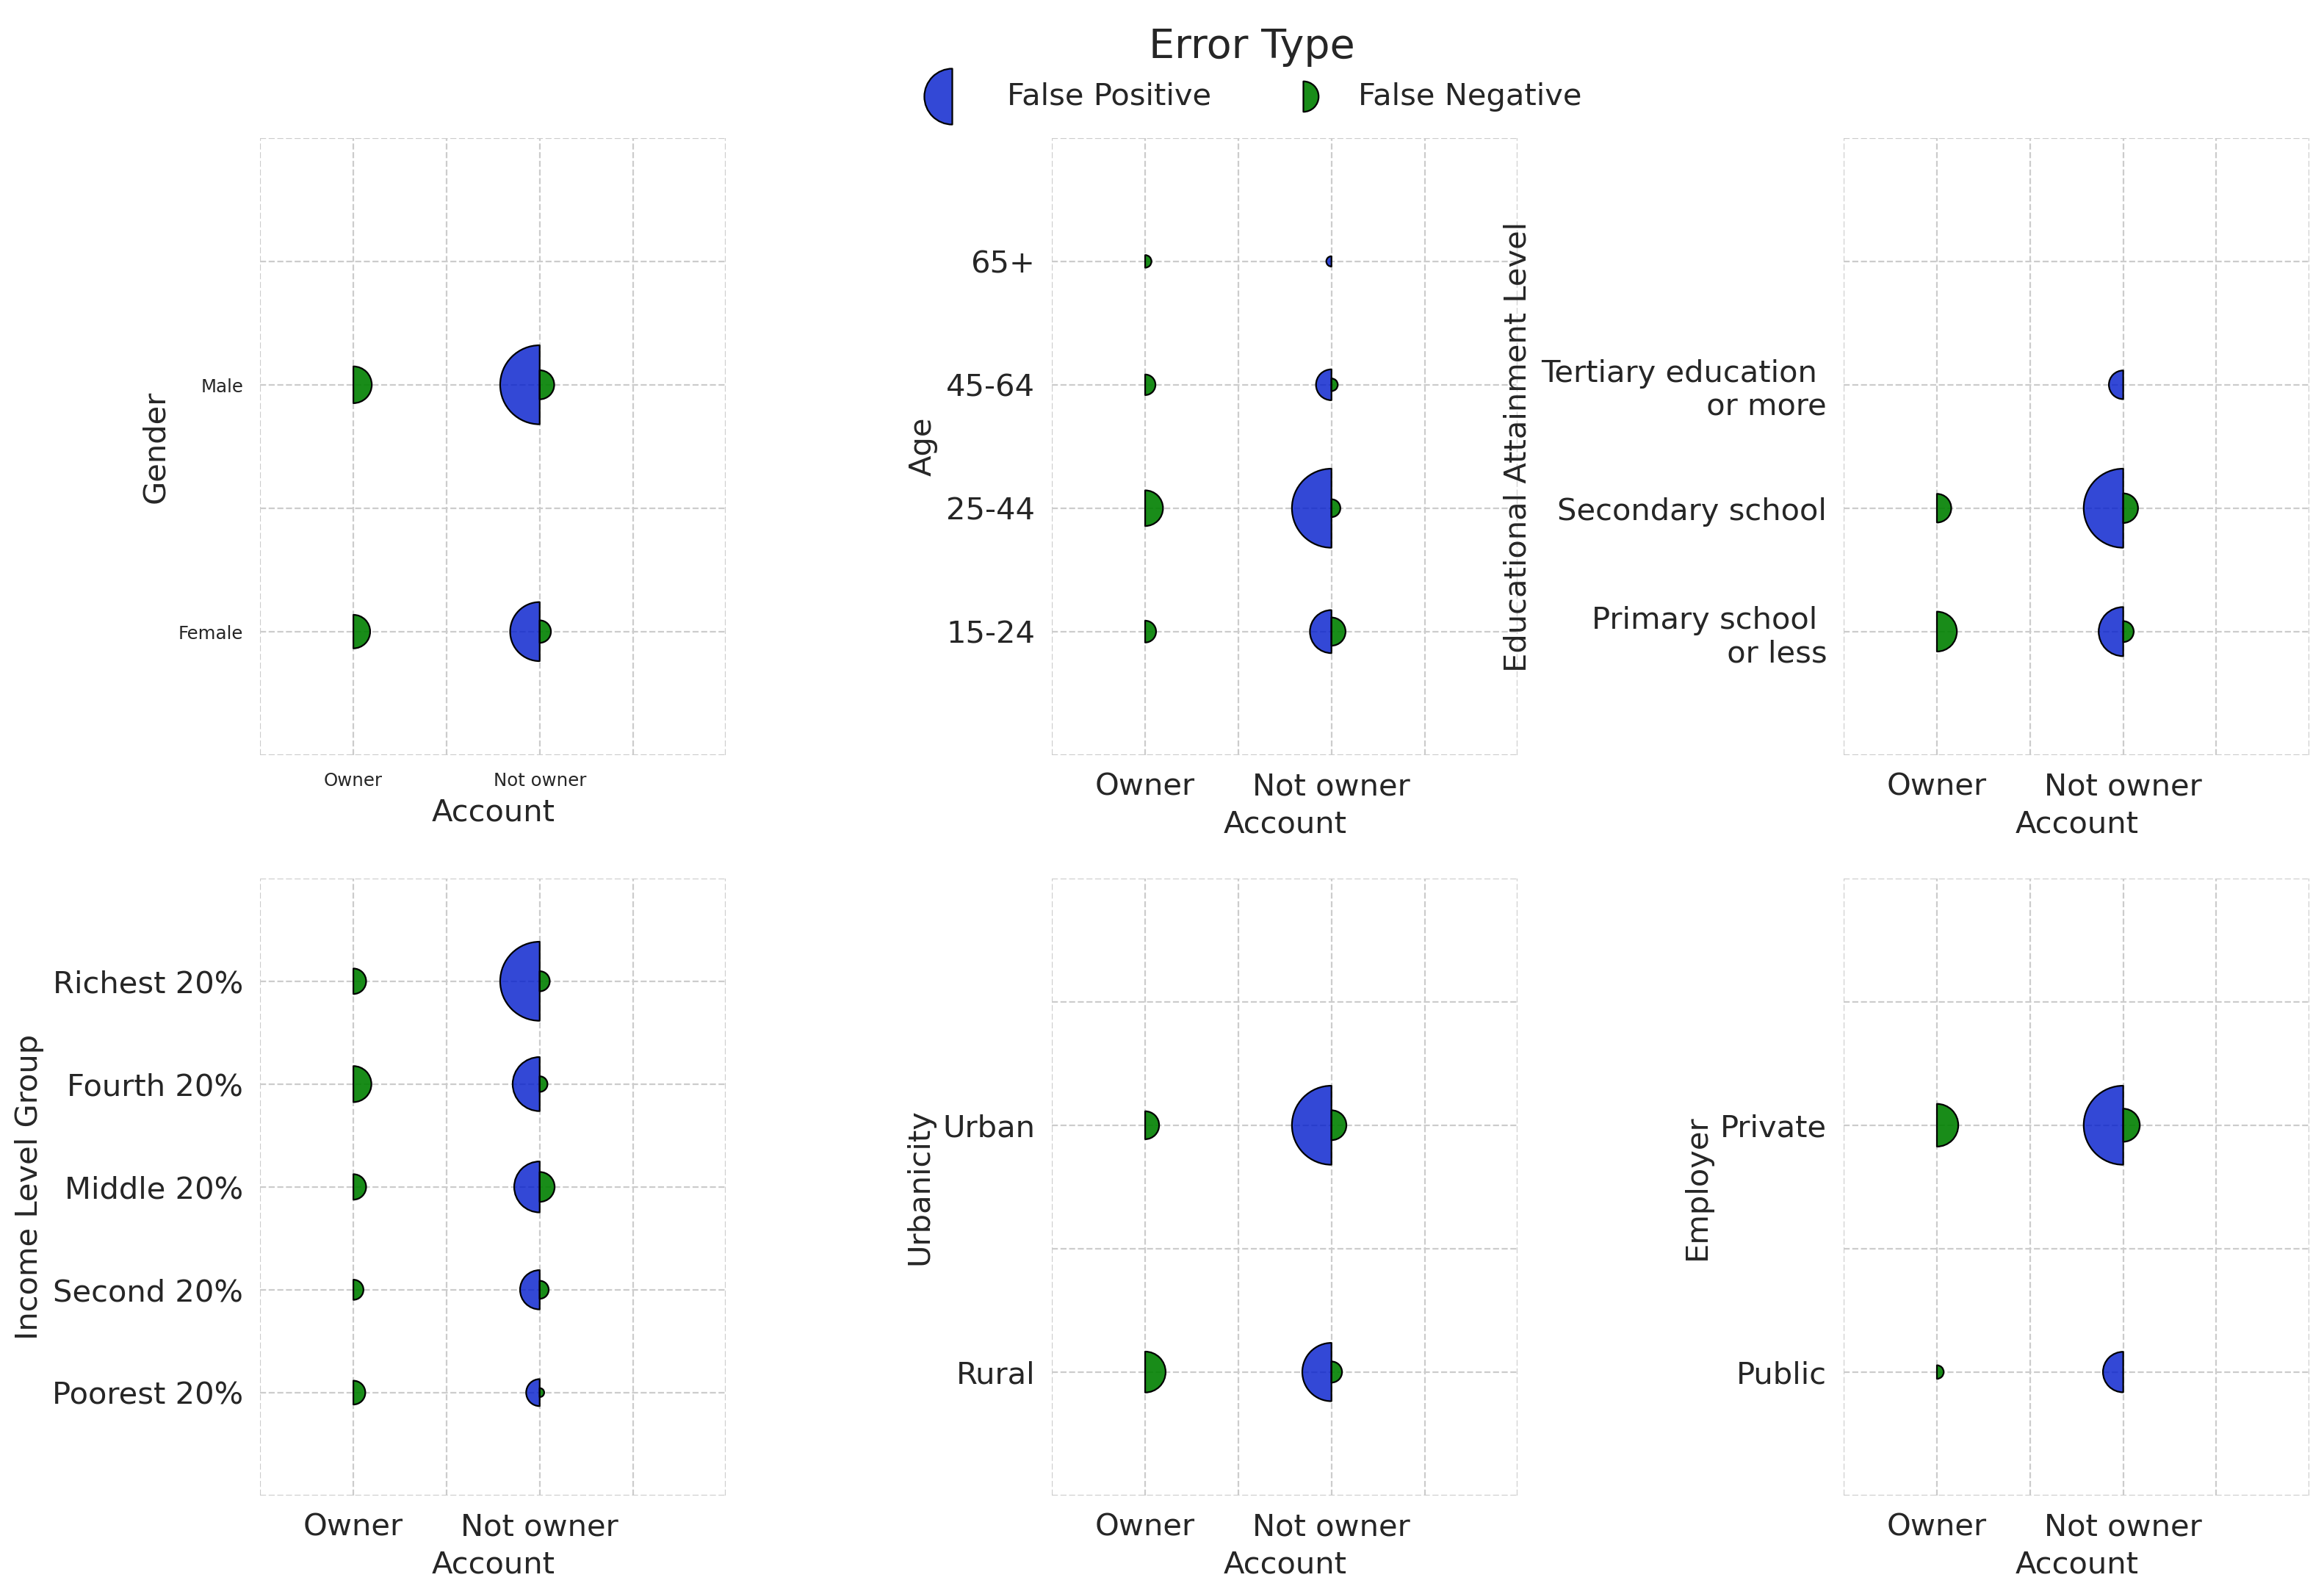

In [315]:
import matplotlib.patches as mpatches
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
fig.subplots_adjust(hspace=0.2, wspace=0.7)
# ax1 = plt.subplot2grid((3, 2), (0, 0))
X ="account" 
Y = "female"
H ="Error Type"
categorical_bubble_plot_g(merged_df, X, Y, H, axs[0][0])
ax1.clear()
X ="account" 
Y = "age"
H ="Error Type"
categorical_bubble_plot_a(merged_df, X, Y, H, axs[0][1])
X ="account" 
Y = "educ"
H ="Error Type"
categorical_bubble_plot_e(merged_df, X, Y, H, axs[0][2])
X ="account" 
Y = "inc_q"
H ="Error Type"
categorical_bubble_plot_i(merged_df, X, Y, H, axs[1][0])
X ="account" 
Y = "urbanicity_f2f"
H ="Error Type"
categorical_bubble_plot_u(merged_df, X, Y, H, axs[1][1])
X ="account" 
Y = "fin33"
H ="Error Type"
categorical_bubble_plot_em(merged_df, X, Y, H, axs[1][2])


# plot the legend entries for the two categories
handles, labels = axs[0][0].get_legend_handles_labels()
fig.legend(handles, labels, title="Error Type", ncol=2, framealpha=0, loc="upper center",
           bbox_to_anchor=(0.5, 0.95), borderaxespad=0., fontsize = 15, title_fontsize=20)
plt.savefig("img/accountmisclassification.png", dpi=500)

In [269]:
plt_df

,educ,inc_q,Error Type,vals
0,1,1,False Negative,5
1,1,1,False Positive,2
2,1,2,False Negative,6
3,1,2,False Positive,7
4,1,3,False Negative,8
5,1,3,False Positive,11
6,1,4,False Negative,11
7,1,4,False Positive,9
8,1,5,False Negative,7
9,1,5,False Positive,15


In [246]:
bubbles_n = 5
bubbles_min = 5*(1+2//50)
bubbles_step = 10*((10-bubbles_min)//(10*(bubbles_n-1)))
for i, bubbles_y in enumerate(np.linspace(0.5, merged_df["Error Type"].unique().size-1, bubbles_n)):
    legend_ax.scatter(0, bubbles_y, s=(bubbles_min + i*bubbles_step),
                      c=[(1, 0, 1, 0.6)], edgecolor="black")
    legend_ax.annotate(bubbles_min+i*bubbles_step, xy=(0.5, bubbles_y),
                        ha="left", va="center", fontsize="large", fontweight="bold", color="black")

In [ ]:
handles, labels = ax.get_legend_handles_labels()
plt.setp(ax.legend(handles[::-1], labels[::-1], title="Error Type", fontsize=15, 
                   bbox_to_anchor=(1, 1)).get_title(), fontsize=15)

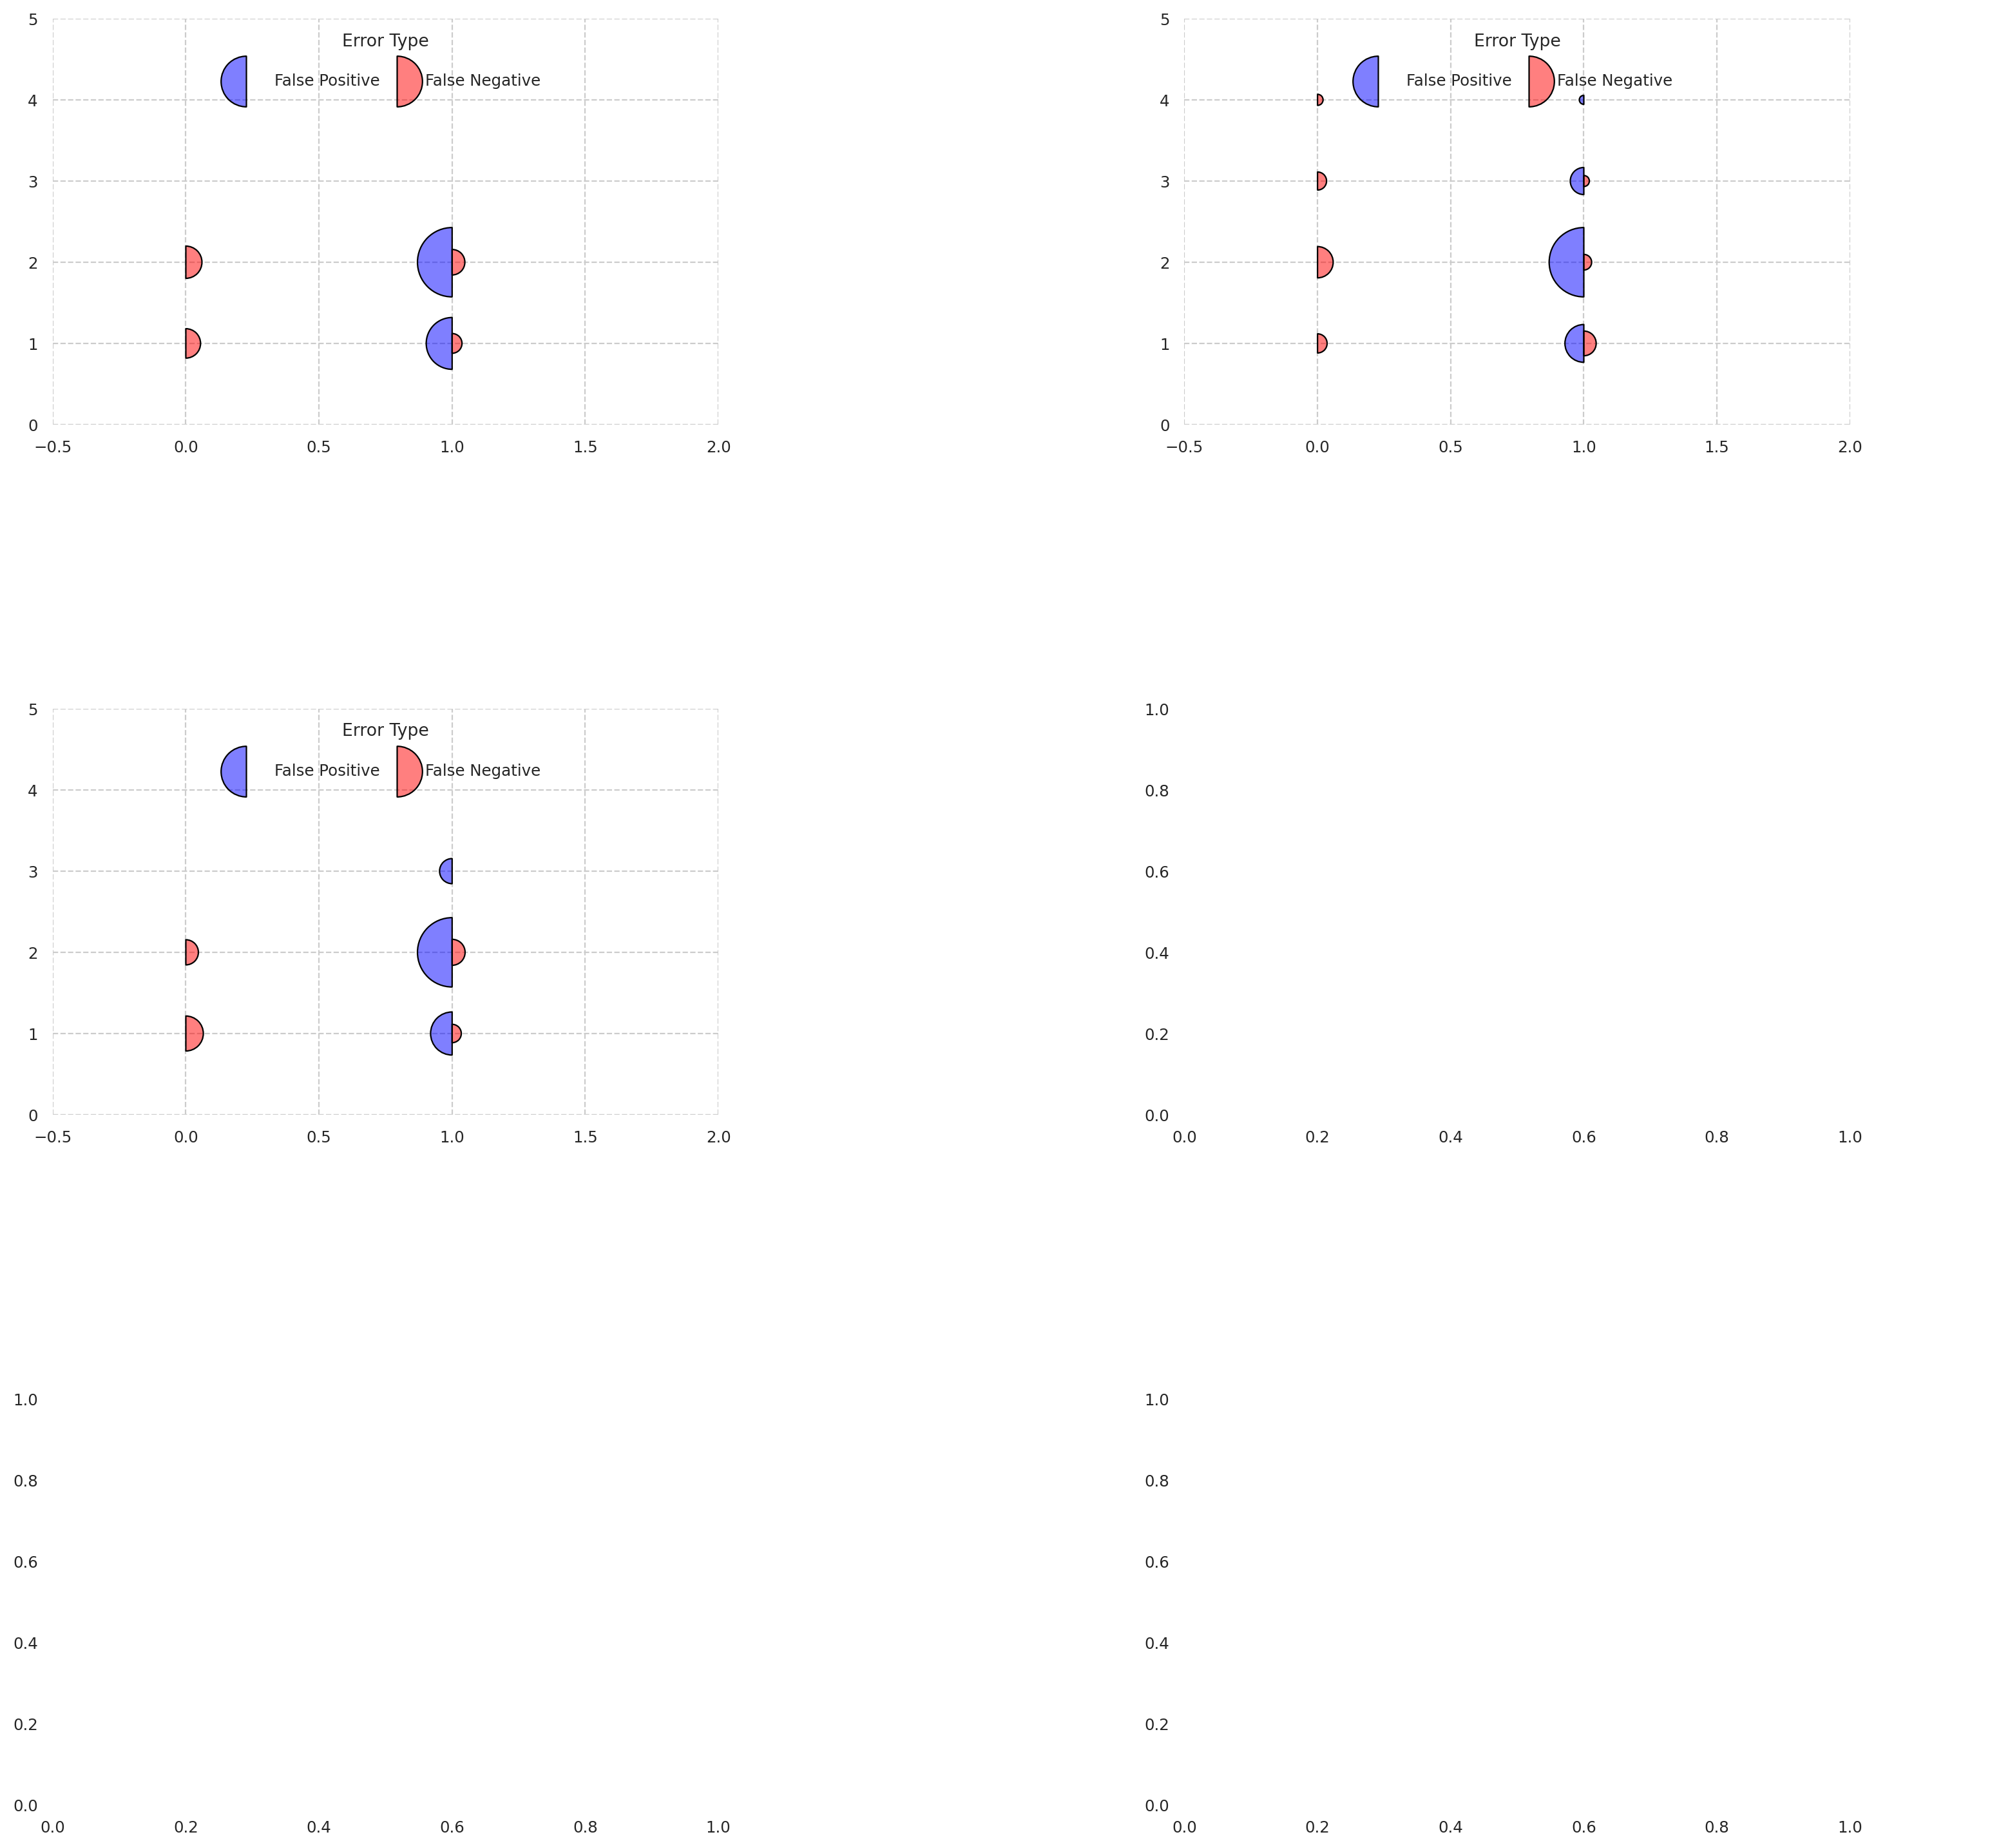

In [207]:
import matplotlib.pyplot as plt
import pandas as pd

def categorical_bubble_plot(dataframe, X, Y, H, ax):
    bin_dic = {0: "False Positive", 1: "False Negative"}

    # counting the X-Y-H category entries
    plt_df = dataframe.groupby([X, Y, H]).size().to_frame(name="vals").reset_index()

    # figure preparation with grid and scaling
#     fig, ax = plt.subplots(figsize=(9, 6))
#     ax.set_ylim(plt_df[Y].unique().size-0.5, -0.5)
#     ax.set_xlim(-0.5, plt_df[X].unique().size+1.0)
    ax.set_ylim(0, 5)
    ax.set_xlim(-0.5, 2)
    ax.grid(ls="--")

    # upscale factor for scatter marker size
    scale=1500/plt_df.vals.max()
    # left marker for category 0
    ax.scatter(plt_df[plt_df[H]==bin_dic[0]][X], 
               plt_df[plt_df[H]==bin_dic[0]][Y], 
               s=plt_df[plt_df[H]==bin_dic[0]].vals*scale, 
               c=[(0, 0, 1, 0.5)], edgecolor="black", marker=MarkerStyle("o", fillstyle="left"), 
               label=bin_dic[0])
    # right marker for category 1
    ax.scatter(plt_df[plt_df[H]==bin_dic[1]][X], 
               plt_df[plt_df[H]==bin_dic[1]][Y], 
               s=plt_df[plt_df[H]==bin_dic[1]].vals*scale, 
               c=[(1, 0, 0, 0.5)], edgecolor="black", marker=MarkerStyle("o", fillstyle="right"), 
               label=bin_dic[1])

    # legend entries for the two categories
    l = ax.legend(title="Error Type", ncol=2, framealpha=0, loc="upper center", columnspacing=0.1, labelspacing=1.5) 
    l.legendHandles[0]._sizes = l.legendHandles[1]._sizes = [800]

    # legend entries representing sizes
    bubbles_n=5
    bubbles_min = 5*(1+plt_df.vals.min()//50)
    bubbles_step = 10*((plt_df.vals.max()-bubbles_min)//(10*(bubbles_n-1)))
    bubbles_x = plt_df[X].unique().size+0.5

    for i, bubbles_y in enumerate(np.linspace(0.5, plt_df[Y].unique().size-1, bubbles_n)): 
        # plot each legend bubble to indicate different marker sizes
        ax.scatter(bubbles_x, 
                   bubbles_y,
                   s=(bubbles_min + i*bubbles_step) * scale,
                   c=[(1, 0, 1, 0.6)], edgecolor="black")
        # and label it with a value
        ax.annotate(bubbles_min+i*bubbles_step, xy=(bubbles_x, bubbles_y), 
                    ha="center", va="center",
                    fontsize="large", fontweight="bold", color="white")
#     a=ax.get_xticks().tolist()
#     a[0], a[1], a[2], a[3], a[4], a[5] ='', 'Owner', '', 'Not owner', '', ''
#     ax.set_xticklabels(a)
#     b=ax.get_yticks().tolist()
#     b[0], b[1], b[2], b[3], b[4], b[5] ='', '15-24', '25-44', '45-64', '65+', ''
#     ax.set_yticklabels(b)
#     plt.xlabel("Account", fontsize=15)
#     plt.ylabel("Age", fontsize=15)
#     plt.show()

# create subplots
fig, axs = plt.subplots(3, 2, figsize=(18, 18))
fig.subplots_adjust(hspace=0.7, wspace=0.7)

# define variables for each subplot
X_values = ["account", "account", "account"]
Y_values = ["female", "age", "educ"]
H_values = ["Error Type", "Error Type", "Error Type"]

# loop over subplots
for i in range(len(X_values)):
    X = X_values[i]
    Y = Y_values[i]
    H = H_values[i]
#     data = merged_df[[X, Y, H, 'count']].groupby([X, Y, H]).sum().reset_index()
    
    # create bubble plot
    categorical_bubble_plot(merged_df, X, Y, H, axs[i//2, i%2])
#     axs[i//2, i%2].set_xlabel(X)
#     axs[i//2, i%2].set_ylabel(Y)
#     axs[i//2, i%2].set_title(H)
    
#     # create legend
#     handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
#     legend = axs[i//2, i%2].legend(handles, labels, loc="upper right", title="Count")
#     legend.get_title().set_fontsize('16')
    
plt.show()